In [9]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

DATA_DIR = "..//DatasetGFT"
ACTIVITY_LABELS = [0, 1, 2, 3, 4, 5]
ACTIVITY_NAMES = [
    "Rest",
    "Fold clothes",
    "Sweep",
    "Walk",
    "Move boxes",
    "Bike"
]

SAMPLING_RATE = 50
WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2
TRIM_SECONDS = 5
TRIM_SAMPLES = TRIM_SECONDS * SAMPLING_RATE

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_enu", "ay_enu", "az_enu", "gx_enu", "gy_enu", "gz_enu"]

In [2]:
def trim_activity_segments(df, trim_samples=TRIM_SAMPLES):
    df = df.copy()
    df.reset_index(drop=True, inplace=True)
    
    df['label_changed'] = df['label'].ne(df['label'].shift())
    df['segment_id'] = df['label_changed'].cumsum()
    
    segments_to_keep = []
    total_original = 0
    total_trimmed = 0
    
    for seg_id in df['segment_id'].unique():
        segment = df[df['segment_id'] == seg_id].copy()
        seg_len = len(segment)
        total_original += seg_len
        
        if seg_len > 2 * trim_samples:
            trimmed_segment = segment.iloc[trim_samples:-trim_samples]
            segments_to_keep.append(trimmed_segment)
            total_trimmed += len(trimmed_segment)
        else:
            print(f"  Skipping segment (label={segment['label'].iloc[0]}, length={seg_len} samples, {seg_len/SAMPLING_RATE:.1f}s) - too short after trimming")
    
    if segments_to_keep:
        df_trimmed = pd.concat(segments_to_keep, ignore_index=True)
        df_trimmed.drop(columns=['label_changed', 'segment_id'], inplace=True)
    else:
        df_trimmed = pd.DataFrame()
    
    print(f"  Trimmed {total_original - total_trimmed} / {total_original} samples ({100*(total_original - total_trimmed)/total_original:.1f}%)")
    print(f"  Kept {total_trimmed} samples across {len(segments_to_keep)} segments")
    
    return df_trimmed

In [3]:
def load_gft_csvs(base_dir):
    subject_dfs = {}
    for subject_id in sorted(os.listdir(base_dir)):
        subject_path = os.path.join(base_dir, subject_id)
        if not os.path.isdir(subject_path):
            continue
        csv_files = glob.glob(
            os.path.join(subject_path, "IMU_GFT_*.csv")
        )
        if len(csv_files) == 0:
            continue
        df = pd.read_csv(csv_files[0])
        
        print(f"\nProcessing {subject_id}:")
        
        df = trim_activity_segments(df)
        
        if len(df) == 0:
            print(f"  Warning: No data left after trimming for {subject_id}")
            continue
        
        subject_dfs[subject_id] = df

    print(f"\n{'='*50}")
    print(f"Successfully loaded {len(subject_dfs)} subjects")
    print(f"{'='*50}")
    return subject_dfs

def split_subjects_60_20_20(subject_dfs):
    subjects = list(subject_dfs.keys())
    np.random.shuffle(subjects)

    n_total = len(subjects)
    n_train = int(0.6 * n_total)
    n_val = int(0.2 * n_total)

    train_subjects = subjects[:n_train]
    val_subjects = subjects[n_train:n_train + n_val]
    test_subjects = subjects[n_train + n_val:]

    print(f"\nDataset Split:")
    print(f"  Train subjects: {len(train_subjects)}")
    print(f"  Val subjects:   {len(val_subjects)}")
    print(f"  Test subjects:  {len(test_subjects)}")

    return (
        [subject_dfs[s] for s in train_subjects],
        [subject_dfs[s] for s in val_subjects],
        [subject_dfs[s] for s in test_subjects]
    )

In [4]:
def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]

def extract_features(window, cols):
    feats = []
    for c in cols:
        x = window[c].values

        # Time-domain
        feats.extend([
            np.mean(x), np.std(x),
            np.min(x), np.max(x),
            np.sqrt(np.mean(x ** 2)),
            np.mean(np.abs(x))
        ])

        # Frequency-domain
        fft_vals = np.fft.rfft(x)
        fft_mag = np.abs(fft_vals)
        feats.extend([
            np.mean(fft_mag),
            np.std(fft_mag),
            np.max(fft_mag),
            np.sum(fft_mag)
        ])

    return feats


def build_dataset(dfs, feature_cols):
    X, y = [], []

    for df in dfs:
        missing = set(feature_cols + ["label"]) - set(df.columns)
        assert not missing, f"Missing columns: {missing}"

        df = df[feature_cols + ["label"]]

        for w in sliding_windows(df):
            if w["label"].nunique() == 1:
                X.append(extract_features(w, feature_cols))
                y.append(w["label"].iloc[0])

    return np.array(X), np.array(y)

In [5]:
def zscore_normalize(X_train, X_val, X_test):
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    std[std == 0] = 1.0
    X_train_norm = (X_train - mean) / std
    X_val_norm = (X_val - mean) / std
    X_test_norm = (X_test - mean) / std    
    return X_train_norm, X_val_norm, X_test_norm

def balance_classes_undersample(X, y, random_state=42):
    np.random.seed(random_state)

    X_balanced = []
    y_balanced = []

    classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()

    print("\nClass distribution before balancing:")
    for c, cnt in zip(classes, counts):
        print(f"  Class {int(c)} ({ACTIVITY_NAMES[int(c)]:15s}): {cnt:5d} samples")

    for cls in classes:
        idx = np.where(y == cls)[0]
        selected_idx = np.random.choice(idx, size=min_count, replace=False)

        X_balanced.append(X[selected_idx])
        y_balanced.append(y[selected_idx])

    X_balanced = np.vstack(X_balanced)
    y_balanced = np.concatenate(y_balanced)

    perm = np.random.permutation(len(y_balanced))
    X_balanced = X_balanced[perm]
    y_balanced = y_balanced[perm]

    print(f"\nBalanced to {min_count} samples per class")
    print(f"Total samples: {len(y_balanced)}")

    return X_balanced, y_balanced

In [6]:
def select_knn_on_validation(X_train, y_train, X_val, y_val):
    params = {
        "n_neighbors": 7,
        "weights": "distance",
        "metric": "euclidean"
    }

    knn = KNeighborsClassifier(**params)
    knn.fit(X_train, y_train)
    y_val_pred = knn.predict(X_val)

    f1 = f1_score(y_val, y_val_pred, average="macro")

    print(f"\nKNN parameters: {params}")
    print(f"Validation F1 (macro): {f1:.4f}")

    return params

In [7]:
def evaluate_on_test(X_train, y_train, X_test, y_test, best_params, title):
    knn = KNeighborsClassifier(**best_params)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    print(f"\n{'='*60}")
    print(f"{title:^60}")
    print(f"{'='*60}")
    print(classification_report(
        y_test, y_pred,
        target_names=ACTIVITY_NAMES,
        digits=4
    ))

    cm = confusion_matrix(y_test, y_pred, labels=ACTIVITY_LABELS)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=ACTIVITY_NAMES,
        yticklabels=ACTIVITY_NAMES,
        cmap="Blues",
        cbar_kws={'label': 'Count'}
    )
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("True", fontsize=12)
    plt.tight_layout()
    plt.show()

    return {
        "precision": precision_score(y_test, y_pred, average="macro"),
        "recall": recall_score(y_test, y_pred, average="macro"),
        "f1": f1_score(y_test, y_pred, average="macro")
    }


Processing Subject01:
  Trimmed 9000 / 110740 samples (8.1%)
  Kept 101740 samples across 9 segments

Processing Subject02:
  Trimmed 9000 / 110563 samples (8.1%)
  Kept 101563 samples across 9 segments

Processing Subject03:
  Trimmed 9000 / 98902 samples (9.1%)
  Kept 89902 samples across 9 segments

Processing Subject04:
  Trimmed 9000 / 106672 samples (8.4%)
  Kept 97672 samples across 9 segments

Processing Subject05:
  Trimmed 9000 / 105411 samples (8.5%)
  Kept 96411 samples across 9 segments

Processing Subject06:
  Trimmed 9000 / 103438 samples (8.7%)
  Kept 94438 samples across 9 segments

Processing Subject07:
  Trimmed 9000 / 108957 samples (8.3%)
  Kept 99957 samples across 9 segments

Processing Subject08:
  Trimmed 9000 / 105612 samples (8.5%)
  Kept 96612 samples across 9 segments

Processing Subject09:
  Trimmed 9000 / 102335 samples (8.8%)
  Kept 93335 samples across 9 segments

Processing Subject10:
  Trimmed 9000 / 110796 samples (8.1%)
  Kept 101796 samples across

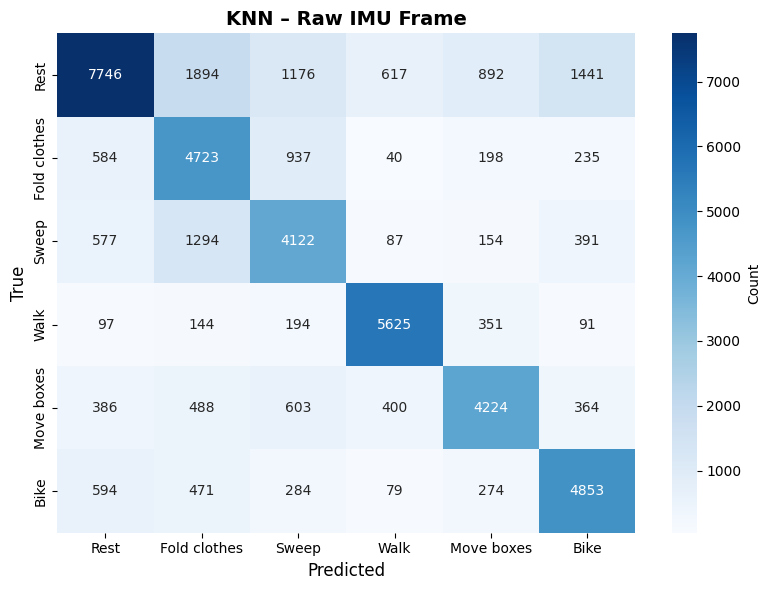


Class distribution before balancing:
  Class 0 (Rest           ): 42595 samples
  Class 1 (Fold clothes   ): 20282 samples
  Class 2 (Sweep          ): 19732 samples
  Class 3 (Walk           ): 19768 samples
  Class 4 (Move boxes     ): 19258 samples
  Class 5 (Bike           ): 19507 samples

Balanced to 19258 samples per class
Total samples: 115548

KNN parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean'}
Validation F1 (macro): 0.6561

                  KNN – Global Frame (ENU)                  
              precision    recall  f1-score   support

        Rest     0.7515    0.6146    0.6762     13766
Fold clothes     0.5236    0.7054    0.6010      6717
       Sweep     0.5030    0.5122    0.5075      6625
        Walk     0.7889    0.7448    0.7662      6502
  Move boxes     0.6989    0.6141    0.6538      6465
        Bike     0.5337    0.6316    0.5785      6555

    accuracy                         0.6336     46630
   macro avg     0.6333    0.6371    

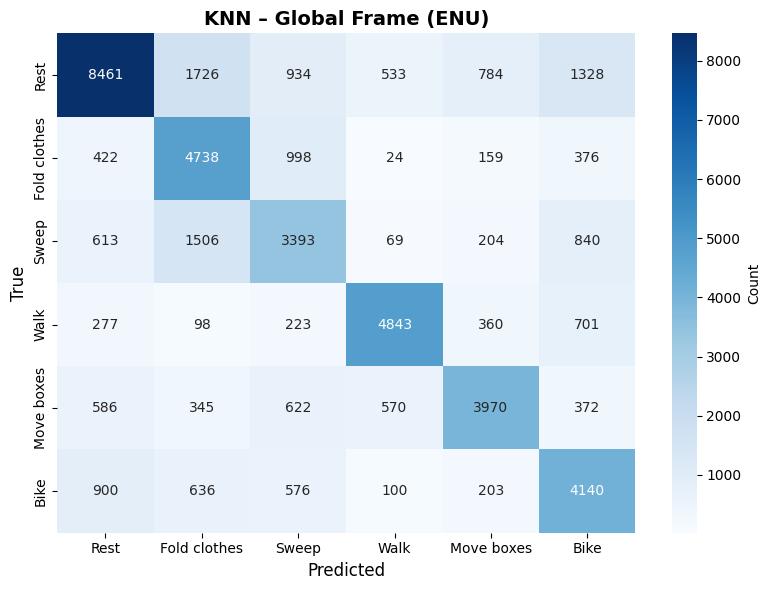

Summary

Raw IMU Frame:
  Precision: 0.6727
  Recall:    0.6911
  F1-Score:  0.6760

Global Frame (ENU):
  Precision: 0.6333
  Recall:    0.6371
  F1-Score:  0.6305


In [10]:
if __name__ == "__main__":
    subject_dfs = load_gft_csvs(DATA_DIR)
    train_dfs, val_dfs, test_dfs = split_subjects_60_20_20(subject_dfs)

    X_train_raw, y_train_raw = build_dataset(train_dfs, RAW_FEATURES)
    X_val_raw, y_val_raw = build_dataset(val_dfs, RAW_FEATURES)
    X_test_raw, y_test_raw = build_dataset(test_dfs, RAW_FEATURES)
    
    X_train_raw, y_train_raw = balance_classes_undersample(
        X_train_raw, y_train_raw
    )
    
    X_train_raw, X_val_raw, X_test_raw = zscore_normalize(
        X_train_raw, X_val_raw, X_test_raw
    )
    
    best_raw_params = select_knn_on_validation(
        X_train_raw, y_train_raw,
        X_val_raw, y_val_raw
    )
    raw_metrics = evaluate_on_test(
        X_train_raw, y_train_raw,
        X_test_raw, y_test_raw,
        best_raw_params,
        "KNN – Raw IMU Frame"
    )


    X_train_gft, y_train_gft = build_dataset(train_dfs, GFT_FEATURES)
    X_val_gft, y_val_gft = build_dataset(val_dfs, GFT_FEATURES)
    X_test_gft, y_test_gft = build_dataset(test_dfs, GFT_FEATURES)
    
    X_train_gft, y_train_gft = balance_classes_undersample(
        X_train_gft, y_train_gft
    )
    
    X_train_gft, X_val_gft, X_test_gft = zscore_normalize(
        X_train_gft, X_val_gft, X_test_gft
    )
    
    best_gft_params = select_knn_on_validation(
        X_train_gft, y_train_gft,
        X_val_gft, y_val_gft
    )
    gft_metrics = evaluate_on_test(
        X_train_gft, y_train_gft,
        X_test_gft, y_test_gft,
        best_gft_params,
        "KNN – Global Frame (ENU)"
    )

    print("Summary")
    print(f"\nRaw IMU Frame:")
    print(f"  Precision: {raw_metrics['precision']:.4f}")
    print(f"  Recall:    {raw_metrics['recall']:.4f}")
    print(f"  F1-Score:  {raw_metrics['f1']:.4f}")
    
    print(f"\nGlobal Frame (ENU):")
    print(f"  Precision: {gft_metrics['precision']:.4f}")
    print(f"  Recall:    {gft_metrics['recall']:.4f}")
    print(f"  F1-Score:  {gft_metrics['f1']:.4f}")